In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install fuzzywuzzy

## **ELTs**

In [ ]:
airbnb_beds_24_historical_data = pd.read_csv('/content/drive/MyDrive/Software_Tools/Pricing_Tool/src/Airbnb and Beds24 Combined Clean Data(Final Data).csv',encoding='ISO-8859-1')
wm_inventory_ds = pd.read_csv('/content/drive/MyDrive/Software_Tools/Pricing_Tool/src/2023_wm_inventory_reservation_details.csv',encoding='ISO-8859-1')
airbnb_full_historical_data = pd.read_csv('/content/drive/MyDrive/Software_Tools/Pricing_Tool/src/airbnb_01_2008-11_2024.csv',encoding='ISO-8859-1')
reservation_tracking_completed = pd.read_csv('/content/drive/MyDrive/Software_Tools/Pricing_Tool/src/Confirmed Bookings Guest Reservation Tracking(completed).csv',encoding='ISO-8859-1')
reservation_tracking_cancelled = pd.read_csv('/content/drive/MyDrive/Software_Tools/Pricing_Tool/src/Confirmed Bookings Guest Reservation Tracking(Cancelled ).csv',encoding='ISO-8859-1')
reservation_tracking_upcoming = pd.read_csv('/content/drive/MyDrive/Software_Tools/Pricing_Tool/src/Confirmed Bookings Guest Reservation Tracking(upcoming bookings).csv',encoding='ISO-8859-1')

In [ ]:
manual_record = pd.read_csv('/content/drive/MyDrive/Software_Tools/Pricing_Tool/src/Booking and Cancellation Manual Record.csv',encoding='ISO-8859-1')

In [ ]:
airbnb_full_historical_data.dropna(subset=['Confirmation code','Gross earnings','Confirmation code'], inplace= True)

In [ ]:
airbnb_full_historical_data = airbnb_full_historical_data[~airbnb_full_historical_data['Confirmation code'].isin(airbnb_beds_24_historical_data['Confirmation code'].unique().tolist())]
airbnb_full_historical_data = airbnb_full_historical_data[airbnb_full_historical_data.Listing.isin(airbnb_beds_24_historical_data.Listing.unique().tolist())]

In [ ]:
airbnb_beds_24_historical_data['Location'] = airbnb_beds_24_historical_data['Location'].str.replace('WorldMark', '').str.strip()
wm_inventory_ds['resort'] = wm_inventory_ds['resort'].str.replace('WorldMark', '').str.strip()

In [ ]:
#compatible_locations = [x for x in airbnb_beds_24_historical_data.Location.unique() if x in wm_inventory_ds.resort.unique()]

In [ ]:
from fuzzywuzzy import fuzz
import numpy as np
import re

beds_24_location_list = [str(loc).replace("WorldMark", "").strip() for loc in airbnb_beds_24_historical_data.Location.unique() if str(loc) != 'nan']
wm_inventory_resort_list = [str(loc).replace("WorldMark", "").strip() for loc in wm_inventory_ds.resort.unique() if str(loc) != 'nan']

matches = {}

for loc1 in beds_24_location_list:
    exact_match_found = False
    for loc2 in wm_inventory_resort_list:
        if loc1 == loc2:  # Check for exact match
            matches[loc1] = [loc2]  # Record only this exact match
            exact_match_found = True
            break
        elif not exact_match_found and fuzz.partial_ratio(loc1, loc2) > 70:  # Fuzzy match if no exact match
            if loc1 not in matches:
                matches[loc1] = []
            matches[loc1].append(loc2)


for loc1, related_locations in matches.items():
    print(f"{loc1} -> {related_locations}")



def map_location_to_resort(df1,mapping_dict,location_tag):
    """
    Transforms the 'Location' column of df1 to match 'resort' column values in df2.

    Parameters:
    df1 (pd.DataFrame): The first dataset with a 'Location' column.
    df2 (pd.DataFrame): The second dataset with a 'resort' column.
    mapping_dict (dict): A dictionary mapping df1 'Location' values to df2 'resort' values.

    Returns:
    pd.DataFrame: Transformed df1 with updated 'Location' values.
    """

    df1_transformed = df1.copy()


    df1_transformed[location_tag] = df1_transformed[location_tag].map(lambda loc: mapping_dict.get(loc, [loc])[0])

    return df1_transformed


def infer_unit_type(unit_description):
    # Search for a number followed by "Bedroom" in the unit description
    match = re.search(r'(\d+)\s*Bedroom', unit_description, re.IGNORECASE)
    if match:
        return float(match.group(1))
    elif 'studio' in unit_description.lower():
        return 1.0
    else:
        return np.nan

Kihei Maui -> ['Kihei']
Parkcity -> ['Park City']
Kona -> ['Kona']
Kihei -> ['Kihei']
Palm Springs -> ['Palm Springs']
Club Wyndham Park City -> ['Park City']
South Shore -> ['South Shore']
Leavenworth -> ['Leavenworth']
Inn at the Park -> ['Estes Park']
Kona Hawaiian -> ['Kona']
Royal Sea Cliff Kona -> ['Kona']
Estes Park -> ['Estes Park']
Yellowstone -> ['West Yellowstone']
California Windsor -> ['Windsor']
Solvang -> ['Solvang']
Indio Resort -> ['Indio']
Steamboat Springs -> ['Steamboat Springs']
Lake Tahoe -> ['Lake Tahoe']
Marina Dunes -> ['Marina Dunes']
Hawaii Kihei -> ['Kihei']
Windsor -> ['Windsor']
Plaza Resort and Spa -> ['Plaza Resort and Spa']


/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
beds_24_historical_mapped = map_location_to_resort(airbnb_beds_24_historical_data,matches,'Location')

In [ ]:
batch_set = wm_inventory_ds[['confirmation',
                             'reservationId',
                             'account',
                             'resort',
                             'checkin',
                             'checkout',
                             'cancel_by',
                             'Unit',
                             'credits',
                             'rented?',
                             'listing?',
                             'cost basis',
                             'target payout',
                             'nights',
                             'booking_date']]

batch_set['Unit Type'] = batch_set['Unit'].apply(infer_unit_type)

training_set = beds_24_historical_mapped[['Confirmation code',
                                               #'Status',
                                               #'Guest name',
                                               #'Contact',
                                               #'# of adults',
                                               #'# of children',
                                               #'# of infants',
                                               'Start date',
                                               'End date',
                                               '# of nights',
                                               'Booked',
                                               'Listing',
                                               'Earnings',
                                               'Location',
                                               'Unit Type']]

<ipython-input-14-4b19fc13e644>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_set['Unit Type'] = batch_set['Unit'].apply(infer_unit_type)


In [ ]:
airbnb_patch_data = airbnb_full_historical_data.merge(
    training_set[['Listing', 'Location', 'Unit Type']],
    on='Listing',
    how='left'
)
airbnb_patch_data.drop_duplicates(subset=['Confirmation code'], inplace=True)

airbnb_patch_data = airbnb_patch_data[['Confirmation code',
                                       'Location',
                                       'Unit Type',
                                       'Start date',
                                       'End date',
                                       'Booking date',
                                       'Gross earnings',
                                       'Nights',
                                       'Listing']].rename(columns={'Gross earnings': 'Earnings', 'Nights': '# of nights', 'Booking date': 'Booked'})

training_set = pd.concat([training_set, airbnb_patch_data], ignore_index=True)

In [ ]:
training_set.dropna(inplace=True)

In [ ]:
reservation_tracking_completed = reservation_tracking_completed[~reservation_tracking_completed['Confirmation code'].isin(training_set['Confirmation code'].unique())]
reservation_tracking_completed['location'] = reservation_tracking_completed['location'].str.replace('WorldMark', '').str.strip()
reservation_tracking_completed = reservation_tracking_completed[reservation_tracking_completed.Listing.isin(training_set.Listing.unique())]
matches = {}
reservation_tracking_completed_resort_list = [str(loc).replace("WorldMark", "").strip() for loc in reservation_tracking_completed.location.unique() if str(loc) != 'nan']
wm_inventory_resort_list = [str(loc).replace("WorldMark", "").strip() for loc in wm_inventory_ds.resort.unique() if str(loc) != 'nan']
for loc1 in reservation_tracking_completed_resort_list:
    exact_match_found = False
    for loc2 in wm_inventory_resort_list:
        if loc1 == loc2:  # Check for exact match
            matches[loc1] = [loc2]  # Record only this exact match
            exact_match_found = True
            break
        elif not exact_match_found and fuzz.partial_ratio(loc1, loc2) > 70:  # Fuzzy match if no exact match
            if loc1 not in matches:
                matches[loc1] = []
            matches[loc1].append(loc2)


for loc1, related_locations in matches.items():
    print(f"{loc1} -> {related_locations}")

<ipython-input-17-81a5d2fc6342>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reservation_tracking_completed['location'] = reservation_tracking_completed['location'].str.replace('WorldMark', '').str.strip()


windsor california -> ['Windsor']
Kihei -> ['Kihei']
Lake Tahoe -> ['Lake Tahoe']
estes park -> ['Estes Park']
Hawaii Kihei -> ['Kihei']
Estes Park -> ['Estes Park']
Yellowstone -> ['West Yellowstone']
South Shore -> ['South Shore']
Park City WM -> ['Park City']
Indio Resort -> ['Indio']
Marina Dunes -> ['Marina Dunes']
Palm Springs -> ['Palm Springs']
Plaza Resort and Spa -> ['Plaza Resort and Spa']
Solvang -> ['Solvang']
Kona -> ['Kona']
Kona Hawaiian Club Wyndham -> ['Kona']


In [ ]:
def calculate_nights(dataset):
    """
    Adds a 'Nights' column to the dataset, calculating the number of nights between the 'Check-in' and 'Check-out' dates,
    while handling mixed or invalid date formats.

    Parameters:
    dataset (pd.DataFrame): A pandas DataFrame with 'Check-in' and 'Check-out' columns.

    Returns:
    pd.DataFrame: The original dataset with an additional 'Nights' column.
    """
    # Handle mixed date formats and invalid dates
    dataset['Check-in'] = pd.to_datetime(
        dataset['Check-in'], errors='coerce', format='%d-%b-%y', dayfirst=True
    )
    dataset['Check-out'] = pd.to_datetime(
        dataset['Check-out'], errors='coerce', format='%d-%b-%y', dayfirst=True
    )

    # Check for invalid dates (set to NaT) and handle them
    if dataset['Check-in'].isna().any() or dataset['Check-out'].isna().any():
        print("Warning: Some dates could not be parsed and were set to NaT.")

    # Calculate nights, avoiding errors with invalid dates
    dataset['Nights'] = (dataset['Check-out'] - dataset['Check-in']).dt.days

    # Optionally, replace NaN values in 'Nights' with a default or flag
    dataset['Nights'] = dataset['Nights'].fillna(-1)  # Use -1 to flag invalid date ranges

    return dataset



reservation_tracking_completed = calculate_nights(reservation_tracking_completed)

In [ ]:
reservation_tracking_completed_mapped = map_location_to_resort(reservation_tracking_completed,matches,'location')
reservation_tracking_completed_patch = reservation_tracking_completed_mapped.merge(
    training_set[['Listing', 'Location', 'Unit Type']],
    on='Listing',
    how='left'
)
reservation_tracking_completed_patch.drop_duplicates(subset=['Confirmation code'], inplace=True)

reservation_tracking_completed_patch = reservation_tracking_completed_patch[['Confirmation code',
                                       'Location',
                                       'Unit Type',
                                       'Check-in',
                                       'Check-out',
                                       'Booked on',
                                       'Total Payout ',
                                       'Nights',
                                       'Listing']].rename(columns={'Total Payout ': 'Earnings', 'Nights': '# of nights', 'Booked on': 'Booked', 'Check-in':'Start date', 'Check-out':'End date'})

training_set = pd.concat([training_set, reservation_tracking_completed_patch], ignore_index=True)

In [ ]:
len(training_set)

2015

In [ ]:
reservation_tracking_cancelled.rename(columns={reservation_tracking_cancelled.columns[0]: 'Location'}, inplace=True)

In [ ]:
reservation_tracking_cancelled = reservation_tracking_cancelled[~reservation_tracking_cancelled['Confirmation code'].isin(training_set['Confirmation code'].unique())]
reservation_tracking_cancelled['Location'] = reservation_tracking_cancelled['Location'].str.replace('WorldMark', '').str.strip()
reservation_tracking_cancelled['Location'] = reservation_tracking_cancelled['Location'].str.replace('pc', 'Park City').str.strip()
reservation_tracking_cancelled = reservation_tracking_cancelled[reservation_tracking_cancelled.Listing.isin(training_set.Listing.unique())]
matches = {}
reservation_tracking_cancelled_resort_list = [str(loc).replace("WorldMark", "").strip() for loc in reservation_tracking_cancelled.Location.unique() if str(loc) != 'nan']
wm_inventory_resort_list = [str(loc).replace("WorldMark", "").strip() for loc in wm_inventory_ds.resort.unique() if str(loc) != 'nan']
for loc1 in reservation_tracking_cancelled_resort_list:
    exact_match_found = False
    for loc2 in wm_inventory_resort_list:
        if loc1 == loc2:  # Check for exact match
            matches[loc1] = [loc2]  # Record only this exact match
            exact_match_found = True
            break
        elif not exact_match_found and fuzz.partial_ratio(loc1, loc2) > 70:  # Fuzzy match if no exact match
            if loc1 not in matches:
                matches[loc1] = []
            matches[loc1].append(loc2)


for loc1, related_locations in matches.items():
    print(f"{loc1} -> {related_locations}")

Park City -> ['Park City']
Estes Park -> ['Estes Park']
Kihei -> ['Kihei']
Marina Dunes -> ['Marina Dunes']
windsor california -> ['Windsor']
Yellowstone -> ['West Yellowstone']
yellowstone -> ['West Yellowstone']
Solvang -> ['Solvang']
Kona -> ['Kona']


<ipython-input-22-517a3befe16b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reservation_tracking_cancelled['Location'] = reservation_tracking_cancelled['Location'].str.replace('WorldMark', '').str.strip()
<ipython-input-22-517a3befe16b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reservation_tracking_cancelled['Location'] = reservation_tracking_cancelled['Location'].str.replace('pc', 'Park City').str.strip()


In [ ]:
#reservation_tracking_cancelled_mapped = map_location_to_resort(reservation_tracking_cancelled,matches,'Location')
reservation_tracking_cancelled_mapped = calculate_nights(reservation_tracking_cancelled)
reservation_tracking_cancelled_patch = reservation_tracking_cancelled_mapped.merge(
    training_set[['Listing', 'Location', 'Unit Type']],
    on='Listing',
    how='left'
)
reservation_tracking_cancelled_patch.drop_duplicates(subset=['Confirmation code'], inplace=True)

reservation_tracking_cancelled_patch = reservation_tracking_cancelled_patch[['Confirmation code',
                                       'Location_x',
                                       'Unit Type',
                                       'Check-in',
                                       'Check-out',
                                       'Booked on',
                                       'Total Payout ',
                                       'Nights',
                                       'Listing']].rename(columns={'Location_x':'Location','Total Payout ': 'Earnings', 'Nights': '# of nights', 'Booked on': 'Booked', 'Check-in':'Start date', 'Check-out':'End date'})

training_set = pd.concat([training_set, reservation_tracking_cancelled_patch], ignore_index=True)

In [ ]:
training_set.dropna(inplace=True)
len(training_set)

2032

In [ ]:
reservation_tracking_upcoming = reservation_tracking_upcoming[~reservation_tracking_upcoming['Confirmation code'].isin(training_set['Confirmation code'].unique())]
reservation_tracking_upcoming['Location'] = reservation_tracking_upcoming['Location'].str.replace('WorldMark', '').str.strip()
reservation_tracking_upcoming['Location'] = reservation_tracking_upcoming['Location'].str.replace('pc', 'Park City').str.strip()
reservation_tracking_upcoming = reservation_tracking_upcoming[reservation_tracking_upcoming.Listing.isin(training_set.Listing.unique())]

matches = {}
reservation_tracking_upcoming_resort_list = [str(loc).replace("WorldMark", "").strip() for loc in reservation_tracking_upcoming.Location.unique() if str(loc) != 'nan']
wm_inventory_resort_list = [str(loc).replace("WorldMark", "").strip() for loc in wm_inventory_ds.resort.unique() if str(loc) != 'nan']
for loc1 in reservation_tracking_upcoming_resort_list:
    exact_match_found = False
    for loc2 in wm_inventory_resort_list:
        if loc1 == loc2:  # Check for exact match
            matches[loc1] = [loc2]  # Record only this exact match
            exact_match_found = True
            break
        elif not exact_match_found and fuzz.partial_ratio(loc1, loc2) > 70:  # Fuzzy match if no exact match
            if loc1 not in matches:
                matches[loc1] = []
            matches[loc1].append(loc2)


for loc1, related_locations in matches.items():
    print(f"{loc1} -> {related_locations}")

Solvang -> ['Solvang']
Windsor -> ['Windsor']
Park City -> ['Park City']
Lake Tahoe -> ['Lake Tahoe']
Lake Tahoe (OLD) -> ['Lake Tahoe']
Lake Tahoe III -> ['Lake Tahoe']
Park city -> ['Park City']
Plaza Resort and Spa -> ['Plaza Resort and Spa']


In [ ]:
reservation_tracking_upcoming_mapped = map_location_to_resort(reservation_tracking_upcoming,matches,'Location')
reservation_tracking_upcoming_mapped = calculate_nights(reservation_tracking_cancelled)
reservation_tracking_upcoming_patch = reservation_tracking_upcoming_mapped.merge(
    training_set[['Listing', 'Location', 'Unit Type']],
    on='Listing',
    how='left'
)
reservation_tracking_upcoming_patch.drop_duplicates(subset=['Confirmation code'], inplace=True)

reservation_tracking_upcoming_patch = reservation_tracking_upcoming_patch[['Confirmation code',
                                       'Location_x',
                                       'Unit Type',
                                       'Check-in',
                                       'Check-out',
                                       'Booked on',
                                       'Total Payout ',
                                       'Nights',
                                       'Listing']].rename(columns={'Location_x':'Location','Total Payout ': 'Earnings', 'Nights': '# of nights', 'Booked on': 'Booked', 'Check-in':'Start date', 'Check-out':'End date'})

training_set = pd.concat([training_set, reservation_tracking_upcoming_patch], ignore_index=True)

In [ ]:
training_set.dropna(inplace=True)
len(training_set)

2051

In [ ]:
# Remove special characters
manual_record['min target'] = manual_record['min target'].replace(
    {'\$': '', ',': ''}, regex=True
)

# Convert to float and coerce errors
manual_record['min target'] = pd.to_numeric(manual_record['min target'], errors='coerce')

# Filter rows where 'min target' is greater than 10.0
manual_record = manual_record[~(manual_record['min target'] < 10.0)]

In [ ]:
manual_record.dropna(subset=['min target'],inplace=True)
manual_record = manual_record[~manual_record.confirmation.isin(training_set['Confirmation code'].unique())]
manual_record['resort'] = manual_record['resort'].str.replace('WorldMark', '').str.strip()
#manual_record['resort'] = manual_record['resort'].str.replace('pc', 'Park City').str.strip()
#manual_record = manual_record[manual_record.Listing.isin(training_set.Listing.unique())]

matches = {}
manual_record_resort_list = [str(loc).replace("WorldMark", "").strip() for loc in manual_record.resort.unique() if str(loc) != 'nan']
wm_inventory_resort_list = [str(loc).replace("WorldMark", "").strip() for loc in wm_inventory_ds.resort.unique() if str(loc) != 'nan']
for loc1 in manual_record_resort_list:
    exact_match_found = False
    for loc2 in wm_inventory_resort_list:
        if loc1 == loc2:  # Check for exact match
            matches[loc1] = [loc2]  # Record only this exact match
            exact_match_found = True
            break
        elif not exact_match_found and fuzz.partial_ratio(loc1, loc2) > 70:  # Fuzzy match if no exact match
            if loc1 not in matches:
                matches[loc1] = []
            matches[loc1].append(loc2)


for loc1, related_locations in matches.items():
    print(f"{loc1} -> {related_locations}")

Park City -> ['Park City']
Kona -> ['Kona']
Lake Tahoe -> ['Lake Tahoe']
Steamboat Springs -> ['Steamboat Springs']
Solvang -> ['Solvang']
Leavenworth -> ['Leavenworth']
Kihei -> ['Kihei']
Windsor -> ['Windsor']
West Yellowstone -> ['West Yellowstone']
Estes Park -> ['Estes Park']
South Shore -> ['South Shore']
UT-Park City -> ['Park City']
Palm Springs -> ['Palm Springs']
HI-Kihei, Maui -> ['Kihei']
NV-South Shore -> ['South Shore']


<ipython-input-29-c3ed63cc3416>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manual_record.dropna(subset=['min target'],inplace=True)


In [ ]:
manual_record_mapped = map_location_to_resort(manual_record,matches,'resort').rename(columns={'checkin':'Check-in','checkout': 'Check-out'})
manual_record_mapped = calculate_nights(manual_record_mapped)
manual_record_mapped['unit'] = manual_record_mapped['unit'].apply(infer_unit_type)
manual_record_mapped['cost basis'] = (
    manual_record_mapped['cost basis']
    .replace('[\$,]', '', regex=True)   # Remove currency symbols and commas
    .replace(r'[^\d.]', np.nan, regex=True)  # Replace non-numeric strings with NaN
    .astype(float)  # Convert to float
)
manual_record_mapped['cost basis'] = pd.to_numeric(manual_record_mapped['cost basis'], errors='coerce')
manual_record_mapped['Price'] = manual_record_mapped['cost basis'] * manual_record_mapped['min target']
manual_record_mapped = manual_record_mapped[['confirmation',
                                       'resort',
                                       'unit',
                                       'Check-in',
                                       'Check-out',
                                       'booking_date',
                                       'Price',
                                       'Nights',
                                       'listing?']].rename(columns={'resort':'Location',
                                                                    'Price': 'Earnings',
                                                                    'Nights': '# of nights',
                                                                    'booking_date': 'Booked',
                                                                    'Check-in':'Start date',
                                                                    'Check-out':'End date',
                                                                    'listing?':'Listing',
                                                                    'confirmation': 'Confirmation code',
                                                                    'unit':'Unit Type'})

training_set = pd.concat([training_set, manual_record_mapped], ignore_index=True)

In [ ]:
len(training_set)

2537

In [ ]:
training_set.dropna(inplace=True)

In [ ]:
len(training_set)

2317

# **DTEXP**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

def get_us_holidays(year):
    return {
        "New Year's Day": datetime(year, 1, 1),
        "Independence Day": datetime(year, 7, 4),
        "Thanksgiving": datetime(year, 11, 28),
        "Christmas": datetime(year, 12, 25),
        "Labor Day": datetime(year, 9, 2),
        "Memorial Day": datetime(year, 5, 27),
        "Veterans Day": datetime(year, 11, 11),
        "Martin Luther King Jr. Day": datetime(year, 1, 15),
        "Columbus Day": datetime(year, 10, 12),
        "Washingtons Birthday": datetime(year, 2, 18),
        "Presidents Day": datetime(year, 2, 19) ,
        "Cochela_Festival_w_1":datetime(year, 4, 12),
        "Cochela_Festival_w_2":datetime(year, 4, 19),
        "Cochela_Festival_w_3":datetime(year, 4, 26),
        "Oktober_Festival_w_1": datetime(year, 10, 11),
        "Oktober_Festival_w_2":datetime(year, 4,18),
        "Oktober_Festival_w_3":datetime(year, 4, 25)

    }


def is_holiday_overlap(checkin, checkout):
    if pd.isnull(checkin) or pd.isnull(checkout):
        return 0
    holidays = get_us_holidays(checkin.year)
    for holiday in holidays.values():
        if checkin <= holiday <= checkout:
            return 1
    return 0




batch_set['checkin'] = pd.to_datetime(batch_set['checkin'], format='%d-%b-%y')
batch_set['checkout'] = pd.to_datetime(batch_set['checkout'], format='%d-%b-%y')
batch_set['booking_date'] = pd.to_datetime(batch_set['booking_date'], format='%d-%b-%y', errors='coerce')
batch_set['booking_date'] = batch_set['booking_date'].fillna(
    pd.to_datetime(batch_set['booking_date'], format='%y-%b-%d', errors='coerce')
)
def parse_dates(date_str):
    for fmt in ('%d-%b-%y', '%m/%d/%Y', '%d/%m/%Y'):
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            continue
    return pd.NaT  # Return NaT if no format matches

training_set['Start date'] = training_set['Start date'].apply(parse_dates)
training_set['End date'] = training_set['End date'].apply(parse_dates)
training_set['Booked'] = pd.to_datetime(training_set['Booked'], format='%d-%b-%y', errors='coerce')
training_set['Booked'] = training_set['Booked'].fillna(
    pd.to_datetime(training_set['Booked'], format='%y-%b-%d', errors='coerce')
)
batch_set['stay_duration'] = (batch_set['checkout'] - batch_set['checkin']).dt.days
batch_set['has_weekend'] = batch_set['checkin'].apply(lambda x: 1 if x.weekday() >= 5 else 0)
batch_set['is_holiday_season'] = batch_set['checkin'].apply(lambda x: 1 if x.month in [12, 1] else 0)
batch_set['holiday_overlap'] = batch_set.apply(
    lambda row: is_holiday_overlap(row['checkin'], row['checkout']), axis=1
)
batch_set['booking_advance_days'] = (batch_set['checkin'] - batch_set['booking_date']).dt.days
batch_set['checkin_year'] = batch_set['checkin'].dt.year

training_set['stay_duration'] = (training_set['End date'] - training_set['Start date']).dt.days
training_set['booking_advance_days'] = (training_set['Start date'] - training_set['Booked']).dt.days
training_set['checkin_year'] = training_set['Start date'].dt.year
training_set['has_weekend'] = training_set['Start date'].apply(lambda x: 1 if x.weekday() >= 5 else 0)
training_set['is_holiday_season'] = training_set['Start date'].apply(lambda x: 1 if x.month in [12, 1] else 0)
training_set['holiday_overlap'] = training_set.apply(
    lambda row: is_holiday_overlap(row['Start date'], row['End date']), axis=1
)

In [ ]:
encoder = LabelEncoder()
batch_set['resort'] = encoder.fit_transform(batch_set['resort'])
training_set['Location'] = encoder.fit_transform(training_set['Location'])

In [ ]:
training_set['Earnings'] = (
    training_set['Earnings']
    .replace({'\$': '', ',': '', r'\((.*?)\)': r'-\1'}, regex=True)
    .astype(float)
)

In [ ]:
training_set = training_set[training_set['Earnings'] > 0]

In [ ]:
#training_set.dropna(subset=['Unit Type','stay_duration','# of nights'],inplace=True)

In [ ]:
#training_set = training_set.sort_values(by='Start date', ascending=True).reset_index(drop=True)

In [ ]:
training_set = training_set[training_set.Earnings <= 40000]

In [ ]:
features = training_set[['Location', 'has_weekend', 'is_holiday_season', '# of nights', 'holiday_overlap', 'Unit Type', 'checkin_year']]
target = pd.DataFrame()
target['Earnings'] = np.log1p(training_set['Earnings'])
target1 = pd.DataFrame()
target1['Earnings'] = training_set['Earnings']

In [ ]:
features.head()

,Location,has_weekend,is_holiday_season,# of nights,holiday_overlap,Unit Type,checkin_year
0,10,0,1,6.0,0,1.0,2022
1,10,0,1,6.0,1,1.0,2022
2,21,1,1,14.0,1,4.0,2020
3,11,0,1,3.0,0,1.0,2023
4,11,0,1,1.0,0,1.0,2022


# XGBoost

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV

model_forest = RandomForestRegressor(n_estimators=100, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model_forest, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')
#grid_search.fit(X_train_scaled, y_train_scaled.ravel())
grid_search.fit(X_train, y_train)

best_model_forest = grid_search.best_estimator_

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

y_pred = best_model_forest.predict(X_test)
y_pred = np.expm1(y_pred)
y_test = np.expm1(y_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Absolute Error: 522.9317504339167
R² Score: 0.66
Mean Absolute Error (MAE): 522.93


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score


xgb = XGBRegressor(objective='reg:squarederror', random_state=42)


param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}


grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

best_params_xgb = grid_search_xgb.best_params_
print(f"Best parameters: {grid_search_xgb.best_params_}")

best_xgb = grid_search_xgb.best_estimator_


cv_scores_xgb = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring='r2')
print("Cross-validated R² (XGBoost):", np.mean(cv_scores_xgb))


log_predictions_xgb = best_xgb.predict(X_test)
original_scale_predictions_xgb = np.expm1(log_predictions_xgb)


mae_xgb = mean_absolute_error(y_test, original_scale_predictions_xgb)
r2_xgb = r2_score(y_test, original_scale_predictions_xgb)
print("Mean Absolute Error (MAE) (XGBoost):", mae_xgb)
print("R² Score (XGBoost):", r2_xgb)

Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.9}
Cross-validated R² (XGBoost): 0.7738939762115479
Mean Absolute Error (MAE) (XGBoost): 502.73846068526467
R² Score (XGBoost): 0.684474766254425


In [ ]:
log_predictions_xgb = best_xgb.predict(X_test)
original_scale_predictions_xgb = np.expm1(log_predictions_xgb)


mae_xgb = mean_absolute_error(y_test, original_scale_predictions_xgb*(1+0.2))
r2_xgb = r2_score(y_test, original_scale_predictions_xgb*(1+0.2))
print("Mean Absolute Error (MAE) (XGBoost):", mae_xgb)
print("R² Score (XGBoost):", r2_xgb)

Mean Absolute Error (MAE) (XGBoost): 561.2991799708198
R² Score (XGBoost): 0.7017063498497009


In [ ]:
import pickle
# If you want to save the best_xgb model:
filename = '/content/drive/MyDrive/Software_Tools/Pricing_Tool/models/Pricing_XGB_69.pkl'
pickle.dump(best_xgb, open(filename, 'wb'))

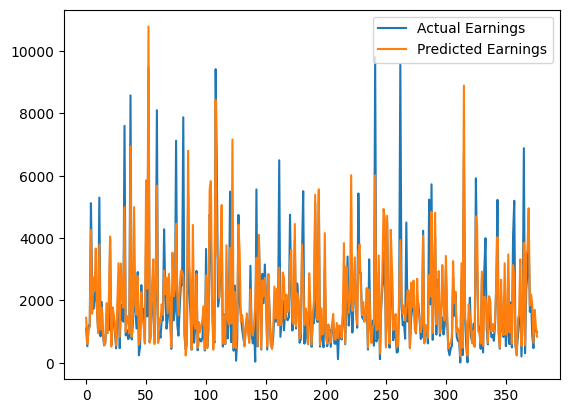

In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs. predicted earnings
plt.plot(y_test.Earnings.values, label='Actual Earnings')
plt.plot(original_scale_predictions_xgb*(1+0.2), label='Predicted Earnings')
plt.legend()
plt.show()

# Plots

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'colab'


# Create a figure
fig = go.Figure()

# Add actual earnings trace
fig.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test.Earnings.values,
    mode='lines',
    name='Actual Earnings',
    line=dict(color='blue')
))

# Add predicted earnings trace
fig.add_trace(go.Scatter(
    x=list(range(len(original_scale_predictions_xgb))),
    y=original_scale_predictions_xgb*(1+0.3),
    mode='lines',
    name='Predicted Earnings',
    line=dict(color='red', dash='dash')
))

# Customize layout
fig.update_layout(
    title='Actual vs. Predicted Earnings',
    xaxis=dict(
        title='Test Sample Number',
        showgrid=True,
        zeroline=False
    ),
    yaxis=dict(
        title='Earnings (USD)',
        showgrid=True,
        zeroline=False
    ),
    legend=dict(
        x=0.5, y=1.2, xanchor='center', orientation='h'
    ),
    template='plotly_white'
)

# Show the figure
fig.show()
